In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(32)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (153): 37089 (0.950279242941359, CCCCCCDCCCCCCCCC)
WORST AGENT (10): 27249 (0.43821706448635106, DCDCCCCCDCCCCCCC)


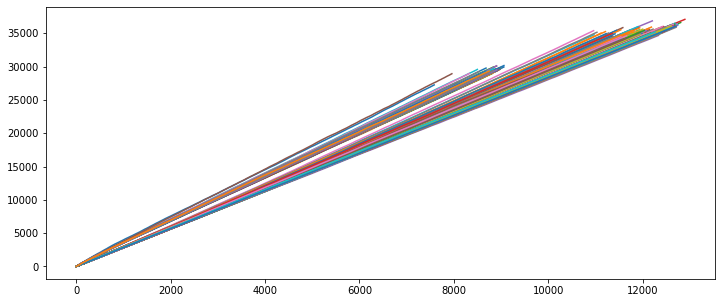

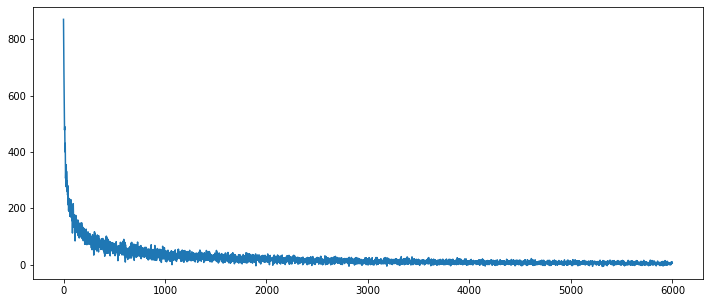

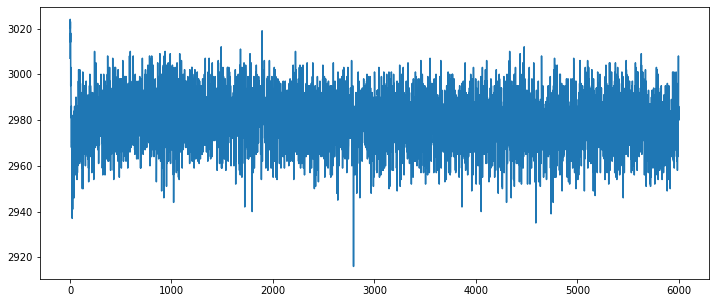

In [6]:
POPULATION = (512,)
ROUNDS = 6_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []

for run in range(1):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()


In [23]:
G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [28]:
from datetime import datetime

dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

nx.drawing.nx_pydot.write_dot(G, f"{dt}.dot")

In [8]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [31]:
weights = sim.calculate_weights()

weights

array([[0.05      , 0.91670439, 0.44444444, ..., 0.73469388, 0.7225    ,
        0.34917355],
       [0.91670439, 0.05      , 0.93444444, ..., 0.36      , 1.        ,
        0.29752066],
       [0.44444444, 0.93444444, 0.05      , ..., 1.        , 0.86828512,
        0.42074507],
       ...,
       [0.73469388, 0.36      , 1.        , ..., 0.05      , 0.8464    ,
        0.37869822],
       [0.7225    , 1.        , 0.86828512, ..., 0.8464    , 0.05      ,
        0.41530864],
       [0.34917355, 0.29752066, 0.42074507, ..., 0.37869822, 0.41530864,
        0.05      ]])

In [37]:
K = nx.Graph()
K.add_weighted_edges_from([
    (i, j, weights[i, j] + weights[j, i])
    for i in range(POPULATION[0])
    for j in range(i + 1, POPULATION[0])
    if i != j and weights[i, j] > 0.7 and weights[j, i] > 0.7
])

nx.drawing.nx_pydot.write_dot(K, f"{dt} - reduced.dot")

In [10]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>]

In [11]:
cumulative_rewards[0][0]

153

In [12]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.96680504e+02 2.29363248e+02]
  [2.60855337e+02 1.07388240e+01]
  [2.44765035e+02 2.35263166e+01]
  [2.08599077e+01 0.00000000e+00]]

 [[2.80714440e+02 8.78773087e+01]
  [1.55450892e+02 2.62375000e-01]
  [6.29993097e+00 2.72470197e+01]
  [5.75159653e+00 0.00000000e+00]]

 [[2.77145649e+02 5.24782481e+01]
  [1.70337426e+02 4.46007624e-01]
  [1.16358420e+02 0.00000000e+00]
  [4.84724785e+00 0.00000000e+00]]

 [[1.08643883e+02 0.00000000e+00]
  [2.55993068e+01 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]


In [13]:
agents[cumulative_rewards[4][0]].play_move([Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE])

<Action.DEFECT: 1>

In [14]:
if hasattr(agents[1], "_q_table"):
    print(agents[1]._q_table)

[[[2.56871797e+02 1.42409947e+02]
  [2.36805274e+02 1.28877438e+01]
  [7.22266032e+01 1.62029125e+02]
  [4.50737600e+01 1.34810211e+00]]

 [[2.51917874e+02 2.69897564e+01]
  [1.51834282e+02 2.46033692e+00]
  [9.05264077e+01 8.96666635e+00]
  [5.88937054e+00 0.00000000e+00]]

 [[2.46305726e+02 3.27432667e+01]
  [9.83483269e+01 4.25784001e+00]
  [2.09334263e+02 4.75551418e+01]
  [5.80498600e+01 1.50021494e+00]]

 [[3.91677367e+01 1.10645671e+02]
  [2.32623092e-01 1.28991774e+01]
  [1.83952529e+01 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]


In [15]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [16]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [17]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

39.0                     CCCDCDCCCDCCCCDC
41.0                     CCCCCDDCCDCCCCDC
43.0                     CCCDDCCCCDDCCCDC
49.0                     CCCCCCCCCCDDCCCC
68.0                     CCCCCCCCDCCDCCCC
75.0                     CCCDCDCCCCCCCCCC
76.0                     CCDCCCCDCCDCCCCC
85.0                     CCCCCCCCCCCDCDCC
90.0                     CCCDCCCCCCCCDCCC
102.0                    CCCCCCCCCCCCCDDC
117.28571428571429       CCCCCCDCCCCCCCCC
124.0                    CCCDCCCCCCCCDCCD
124.08333333333333       CCCCCDCCCCCCCCCC
124.75                   CCCCCCCCDCCCCCCC
148.83333333333334       CCCCCCCCCCCCCCDC
171.0                    CCDDCCCCCCDCCCCC
176.7                    CCCDCCCCCCCCCCCC
189.0                    CCCCCCDCCCCCDCCC
190.0625                 CCCCCCCDCCCCCCCC
195.74111675126903       CCCCCCCCCCCCCCCC
201.0                    CDCCCCDCCCCCCDCC
204.0                    CCCCDCDCCCCCCCCC
204.33333333333334       CCCCCCCCCCDCCCCC
207.0                    CCDCCCCDC

In [18]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

36003.0                  CCCDCDCCCDCCCCDC
35996.0                  CCCCCDDCCDCCCCDC
35987.0                  CCCDDCCCCDDCCCDC
35968.0                  CCCCCCCCCCDDCCCC
35887.0                  CCCCCCCCDCCDCCCC
35884.42857142857        CCCCCCDCCCCCCCCC
35853.0                  CCCDCDCCCCCCCCCC
35845.0                  CCDCCCCDCCDCCCCC
35810.0                  CCCCCCCCCCCDCDCC
35794.0                  CCCDCCCCCCCCDCCC
35765.666666666664       CCCCCDCCCCCCCCCC
35747.0                  CCCCCCCCCCCCCDDC
35679.0                  CCCCCCCCDCCCCCCC
35671.0                  CCCDCCCCCCCCDCCD
35660.666666666664       CCCCCCCCCCCCCCDC
35563.45                 CCCDCCCCCCCCCCCC
35529.0                  CCDDCCCCCCDCCCCC
35501.8125               CCCCCCCDCCCCCCCC
35487.0                  CCCCCCDCCCCCDCCC
35481.53299492386        CCCCCCCCCCCCCCCC
35449.0                  CCCCCCCCCCDCCCCC
35442.5                  CCDCCCCDCCCCCCCC
35439.0                  CDCCCCDCCCCCCDCC
35430.0                  CCCCDCDCC

In [19]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CCCCCCDCCCCCCCCC'

In [20]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.96680504e+02 2.29363248e+02]
  [2.60855337e+02 1.07388240e+01]
  [2.44765035e+02 2.35263166e+01]
  [2.08599077e+01 0.00000000e+00]]

 [[2.80714440e+02 8.78773087e+01]
  [1.55450892e+02 2.62375000e-01]
  [6.29993097e+00 2.72470197e+01]
  [5.75159653e+00 0.00000000e+00]]

 [[2.77145649e+02 5.24782481e+01]
  [1.70337426e+02 4.46007624e-01]
  [1.16358420e+02 0.00000000e+00]
  [4.84724785e+00 0.00000000e+00]]

 [[1.08643883e+02 0.00000000e+00]
  [2.55993068e+01 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]


In [21]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => D
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
